<h1>Выпускной проект
    
    Тема проекта: Промышленность

**Цель проекта:**
Снижение потребления  электроэнергии  на этапе обработки стали для металлургического комбината ООО «Так закаляем сталь».

**Задача проекта:**
Построить модель, которая предскажет температуру стали

**Описание этапа обработки:**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

**План работы:**
- Загрузка и проверка данных
- Предобработка и анализ данных
- Подготовка данных для обучения
- Создание и обучение моделей
- Тестирование моделей 
- Анализ важности факторов

# Загрузка и проверка данных 

**Импортируем библиотеки**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from scipy.spatial import distance
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.preprocessing import StandardScaler

**Откроем файлы с данными и изучим общую информацию**

In [7]:
try: 
    data_arc_new = pd.read_csv('data_arc_new.csv')
    data_bulk_new = pd.read_csv('data_bulk_new.csv')
    data_bulk_time_new = pd.read_csv('data_bulk_time_new.csv')
    data_gas_new = pd.read_csv('data_gas_new.csv')
    data_temp_new = pd.read_csv('data_temp_new.csv')
    data_wire_new = pd.read_csv('data_wire_new.csv')
    data_wire_time_new = pd.read_csv('data_wire_time_new.csv')
except:
    print('Error')

# Описание данных

- `data_arc_new` — данные об электродах;
- `data_bulk_new` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new` *—* данные о подаче сыпучих материалов (время);
- `data_gas_new` — данные о продувке сплава газом;
- `data_temp_new` — результаты измерения температуры;
- `data_wire_new` — данные о проволочных материалах (объём);
- `data_wire_time_new` — данные о проволочных материалах (время).

Данные получены из разных источников. Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

#### Данные об электродах

In [8]:
data_arc_new.tail(8)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
14868,3240,2019-09-06 15:58:45,2019-09-06 16:01:15,0.382519,0.232164
14869,3240,2019-09-06 16:02:41,2019-09-06 16:07:15,0.496953,0.416185
14870,3240,2019-09-06 16:21:54,2019-09-06 16:24:15,1.202454,0.846936
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543
14875,3241,2019-09-06 17:24:54,2019-09-06 17:26:15,0.389057,0.251347


In [9]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [10]:
data_arc_new.duplicated().sum()

0

В таблице 14876 строк, пропусков нет, тип данных во временных столбцах необходимо перевести в тип datetime, в остальных столбцах тип данных соответствует содержимому. Дубликаты в таблице отсутствуют.

In [11]:
print(data_arc_new['key'].unique())
data_arc_new['key'].value_counts()

[   1    2    3 ... 3239 3240 3241]


2108    16
1513    15
1689    15
2567    14
46      13
        ..
112      1
2472     1
2025     1
3059     1
1615     1
Name: key, Length: 3214, dtype: int64

Есть повторяющиеся значения в столбце key, что соответствует итерациям процесса обработки. Максимальное число итераций - 16.

In [12]:
print(data_arc_new['Начало нагрева дугой'].is_monotonic)
data_arc_new['Конец нагрева дугой'].is_monotonic

True


True

Проверка временного ряда на монотонность показывает, что временные данные последовательны

In [13]:
print('Активная мощность')
print(data_arc_new['Активная мощность'].describe() )
print()

print('Реактивная мощность')
print(data_arc_new['Реактивная мощность'].describe() )
print()

Активная мощность
count    14876.000000
mean         0.662752
std          0.258885
min          0.223120
25%          0.467115
50%          0.599587
75%          0.830070
max          1.463773
Name: Активная мощность, dtype: float64

Реактивная мощность
count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: Реактивная мощность, dtype: float64



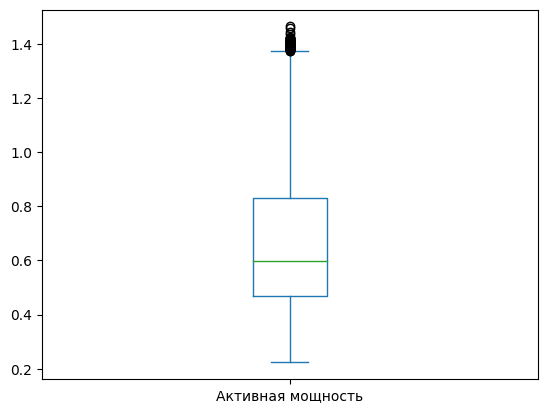

In [14]:
data_arc_new['Активная мощность'].plot.box()
plt.show()

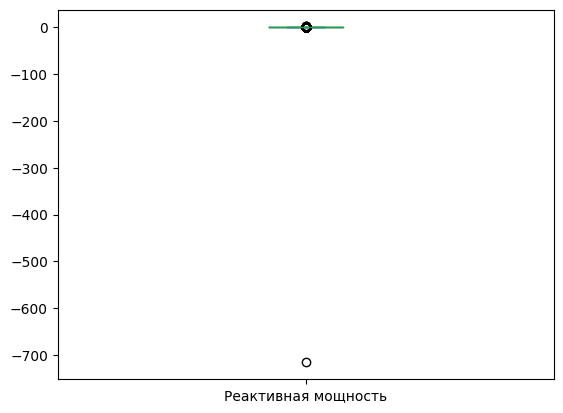

In [15]:
data_arc_new['Реактивная мощность'].plot.box()
plt.show()

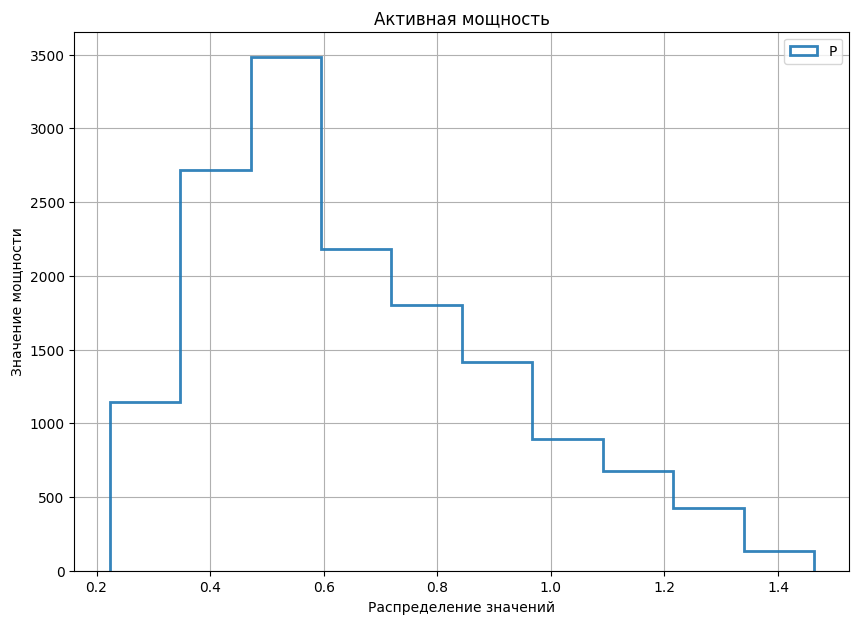

In [16]:
plt.title('Активная мощность')

ax=data_arc_new['Активная мощность'].plot(kind='hist',figsize=(10,7),
                       grid=True, legend=True, 
                       alpha=0.9, histtype='step', 
                       linewidth=2, label='P')

plt.xlabel('Распределение значений')
plt.ylabel('Значение мощности')
plt.show()

Данные по мощностям распределены: для активной в диапазоне от 0.22 до 0.46, для реактивной от 0.3 до 1.2. Выбросы в реактивной мощности будем считать недостоверными данными.

Активная мощность P является полезной мощностью и идет на нагрев сплава. Активная мощность определяет скорость полезного потребления энергии. Реактивная мощность Q не является полезной мощностью, но является частью полной мощности. Полную мощность S, потребляемую при нагреве сплава можно получить по формуле:

$$
S = {\sqrt{P^2 + Q^2}} $$

**Вывод по таблице data_arc_new**

- В таблице 14876 строк, пропусков нет, тип данных во временных столбцах необходимо перевести в тип datetime, в остальных столбцах тип данных соответствует содержимому. Явные дубликаты в таблице отсутствуют.
- Есть повторяющиеся значения в столбце key, что соответствует итерациям процесса обработки. Максимальное число итераций - 16.
- Проверка временного ряда на монотонность показывает, что временные данные последовательны. 
- Данные по мощностям распределены: для активной в диапазоне от 0.22 до 0.46 ед, для реактивной от 0.3 до 1.2 ед. Выбросы в реактивной мощности будем считать недостоверными данными.

#### Данные о подаче сыпучих материалов (объём)

In [17]:
data_bulk_new.tail(10)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
3119,3232,NaN,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,92.0,204.0
3120,3233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,114.0,204.0
3121,3234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,262.0,204.0
3122,3235,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.0,NaN,118.0,206.0
3123,3236,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,132.0,208.0
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0
3128,3241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180.0,52.0


In [18]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [19]:
data_bulk_new.duplicated().sum()

0

Гистограммы для data_bulk_new


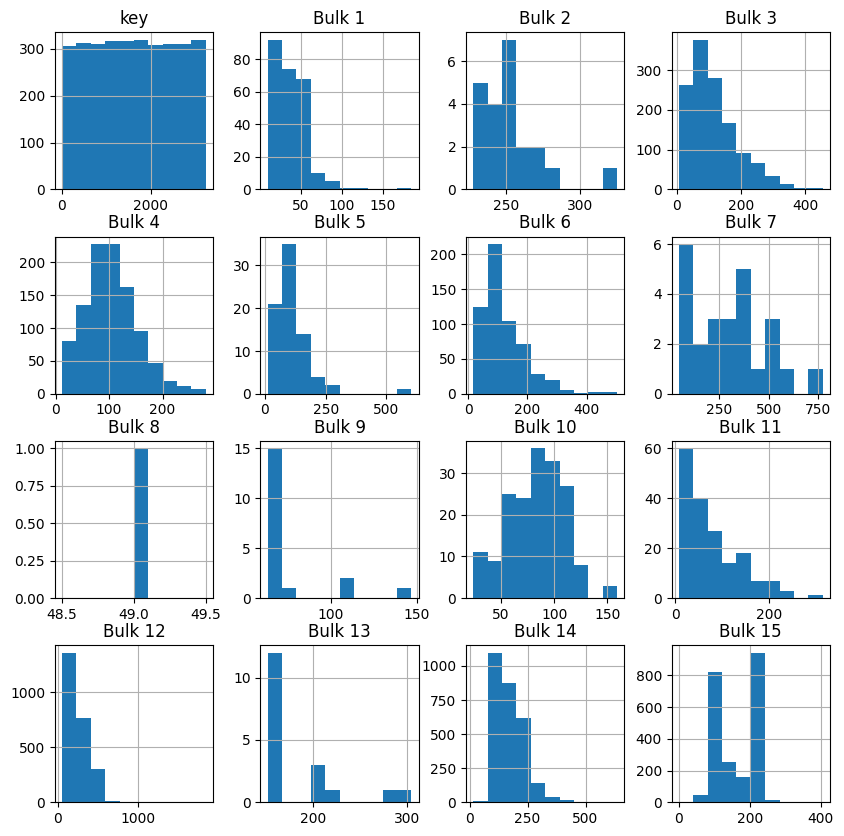

In [20]:
print('Гистограммы для data_bulk_new')
data_bulk_new.hist(figsize=(10, 10))
plt.show()

В таблице 3129 строк, пропуски есть, тип данных в столбцах соответствует содержимому. Явные дубликаты в таблице отсутствуют. Столбцы Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 13  имеют малое число данных, поэтому их можно удалить, как незначительные.

In [21]:
data_bulk_new['key'].value_counts()

1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: key, Length: 3129, dtype: int64

В столбце key дубликатов нет.

**Вывод по таблице data_bulk_new**
- В таблице 3129 строк, тип дпнных соответствует содержимому. Явные дубликаты в таблице отсутствуют. В каждом столбце Bulk есть пропуски в данных. В столбце с ключами пропусков нет.
- Столбцы Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 13  имеют сравнительно небольшое число данных, поэтому их можно удалить, как незначительные.
- В столбце key дубликатов нет.

#### Данные о подаче сыпучих материалов (время)

In [22]:
data_bulk_time_new.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:28:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:24:31,NaN,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaN,NaN,NaN,2019-05-03 11:36:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:53:30,NaN,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaN,NaN,NaN,2019-05-03 12:32:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:27:13,NaN,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaN,NaN,NaN,2019-05-03 12:43:22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:58:00,NaN,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:30:47,NaN,2019-05-03 13:34:12,2019-05-03 13:30:47


In [23]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [24]:
data_bulk_time_new.duplicated().sum()

0

In [25]:
data_bulk_time_new['key'].value_counts()

1       1
2174    1
2152    1
2153    1
2154    1
       ..
1092    1
1093    1
1094    1
1095    1
3241    1
Name: key, Length: 3129, dtype: int64

**Вывод по таблице data_bulk_time_new:**
- В таблице 3129 строк, тип данных в столбцах Bulk нужно изменить на datetime . Явные дубликаты в таблице отсутствуют. В каждом столбце Bulk есть пропуски в данных. В столбце с ключами пропусков нет.
- Таблица является дополнением к таблице data_bulk_new. 
- Столбцы Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 13 также можно удалить.

#### Данные о продувке сплава газом 

In [26]:
data_gas_new.tail(5)

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [27]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [28]:
data_gas_new.duplicated().sum()

0

В таблице 3239 строк, пропусков нет, тип данных в столбцах соответствует содержимому. Явные дубликаты в таблице отсутствуют.

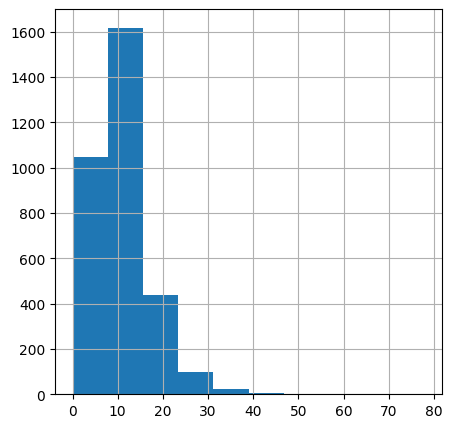

In [29]:
data_gas_new['Газ 1'].hist(figsize=(5, 5))
plt.show()

In [30]:
data_gas_new['Газ 1'].describe() 

count    3239.000000
mean       11.002062
std         6.220327
min         0.008399
25%         7.043089
50%         9.836267
75%        13.769915
max        77.995040
Name: Газ 1, dtype: float64

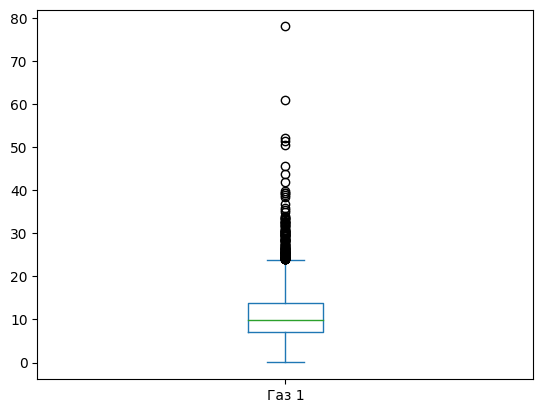

In [31]:
data_gas_new['Газ 1'].plot.box()
plt.show()

Среднее количество газа 11 ед.,  медианное 9,8 ед. Т.к. присутствуют выбросы в данных столбца `Газ 1`, значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения.

In [32]:
data_gas_new['key'].value_counts()

1       1
2166    1
2156    1
2157    1
2158    1
       ..
1086    1
1087    1
1088    1
1089    1
3241    1
Name: key, Length: 3239, dtype: int64

Повторений в столбце key нет

**Вывод по таблице data_gas_new:**
- В таблице 3239 строк, пропусков нет, тип данных в столбцах соответствует содержимому. Явные дубликаты в таблице отсутствуют.
- Повторений в столбце key нет
- Среднее количество газа 11 ед.,  медианное 9,8 ед. Т.к. присутствуют выбросы в данных столбца `Газ 1`, значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения.

#### Результаты измерения температуры

In [33]:
data_temp_new.tail(8)

,key,Время замера,Температура
18084,3240,2019-09-06 16:21:44,NaN
18085,3240,2019-09-06 16:35:26,NaN
18086,3241,2019-09-06 16:48:55,1586.0
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN
18091,3241,2019-09-06 17:30:05,NaN


In [34]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18092 non-null  int64  
 1   Время замера  18092 non-null  object 
 2   Температура   14665 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 424.2+ KB


In [35]:
data_temp_new.duplicated().sum()

0

In [36]:
data_temp_new['key'].value_counts()

2108    17
1513    16
1689    16
2567    15
46      14
        ..
247      2
1169     2
246      2
195      1
279      1
Name: key, Length: 3216, dtype: int64

В таблице 18092 строк, пропуски есть в столбце `Температура`, тип данных в столбцах, кроме `Время замера`,  соответствует содержимому. Тип данных временного столбца нужно изменить на datetime. Явные дубликаты в таблице отсутствуют.
Есть повторения в столбце key.

In [37]:
data_temp_new['Время замера'].is_monotonic

False

В столбце `Время замера` не определяется временная последовательность

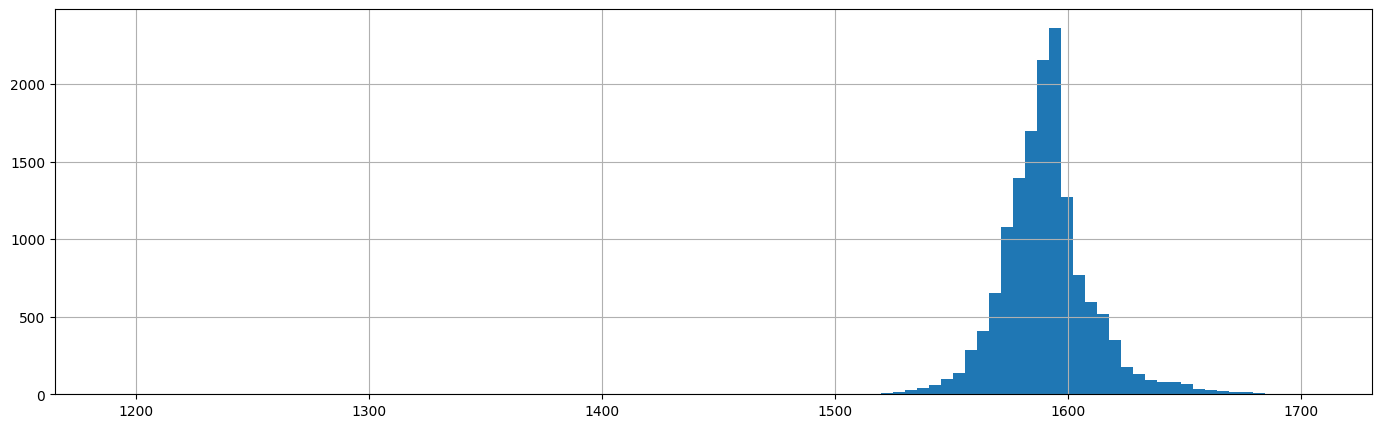

In [38]:
data_temp_new['Температура'].hist(bins=100, figsize=(17,5))
plt.show()

count    14665.000000
mean      1590.722741
std         20.394381
min       1191.000000
25%       1580.000000
50%       1590.000000
75%       1599.000000
max       1705.000000
Name: Температура, dtype: float64

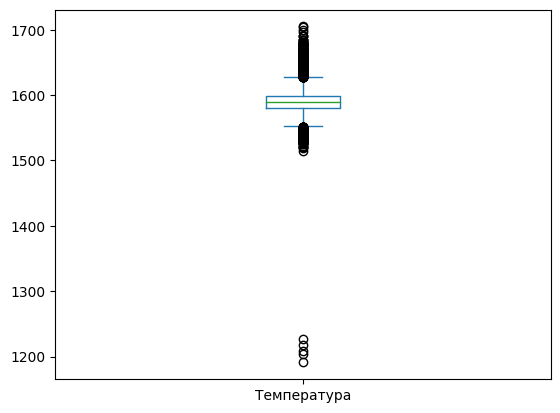

In [39]:
data_temp_new['Температура'].plot.box()
data_temp_new['Температура'].describe() 

Медианное значение температуры 1590 град. Данные ниже 1500 град. будем считать недостоверными, строки с этими данными можно удалить. Значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения.

**Вывод по таблице data_temp_new:**
- В таблице 18092 строк, пропуски есть в столбце `Температура`, тип данных в столбцах, кроме `Время замера`,  соответствует содержимому. Тип данных временного столбца нужно изменить на datetime. Явные дубликаты в таблице отсутствуют. 
- Есть повторения в столбце key.
- Медианное значение температуры 1590 град. Данные ниже 1500 град. будем считать недостоверными, строки с этими данными можно удалить. Значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения.

#### Данные о проволочных материалах (объём)

In [40]:
data_wire_new.tail(7)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3074,3235,125.099525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,101.162880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,63.117595,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [42]:
data_wire_new.duplicated().sum()

0

In [43]:
data_wire_new['key'].value_counts()

1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: key, Length: 3081, dtype: int64

В таблице 3081 строка, пропуски есть во всех столбцах, кроме столбца  `key`, тип данных в столбцах соответствует содержимому. Явные дубликаты в таблице отсутствуют. Повторений в столбце key нет. Столбцы с 3 по 9 не содержат значительное количество данных, можно удалить. После удаления столбцов объединить с таблицей data_wire_time_new.

In [44]:
print(data_wire_new['Wire 1'].describe() )
print()
print(data_wire_new['Wire 2'].describe() )

count    3055.000000
mean      100.895853
std        42.012518
min         1.918800
25%        72.115684
50%       100.158234
75%       126.060483
max       330.314424
Name: Wire 1, dtype: float64

count    1079.000000
mean       50.577323
std        39.320216
min         0.030160
25%        20.193680
50%        40.142956
75%        70.227558
max       282.780152
Name: Wire 2, dtype: float64


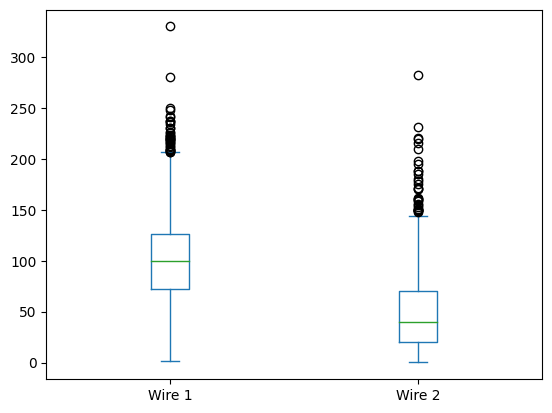

In [45]:
data_wire_new[['Wire 1', 'Wire 2']].plot.box()
plt.show()

В данных `Wire 1`, `Wire 2` есть выбросы, значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения либо удалить. 

**Вывод по таблице data_wire_new:**
- В таблице 3081 строка, пропуски есть во всех столбцах, кроме столбца  `key`, тип данных в столбцах соответствует содержимому. Явные дубликаты в таблице отсутствуют. 
- Повторений в столбце key нет. 
- Столбцы с 3 по 9 не содержат значительное количество данных, можно удалить. После удаления столбцов объединить с таблицей data_wire_time_new.
- В данных `Wire 1`, `Wire 2` есть выбросы, значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения либо удалить. 

#### Данные о проволочных материалах (время)

In [46]:
data_wire_time_new.tail(7)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
3074,3235,2019-09-06 10:21:23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3075,3236,2019-09-06 10:57:48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3076,3237,2019-09-06 11:33:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-09-06 12:18:35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-06 14:36:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-06 15:33:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3080,3241,2019-09-06 17:10:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [48]:
data_wire_time_new.duplicated().sum()

0

In [49]:
data_wire_time_new['key'].value_counts()

1       1
2226    1
2146    1
2147    1
2148    1
       ..
1090    1
1091    1
1092    1
1093    1
3241    1
Name: key, Length: 3081, dtype: int64

В таблице 3081 строка, пропуски есть во всех столбцах, кроме столбца  `key`. Тип данных временных столбцов нужно изменить на datetime. Явные дубликаты в таблице отсутствуют. Повторений в столбце key нет. Столбцы с 3 по 9 не содержат значительное количество данных, можно удалить. После удаления столбцов объединить с таблицей data_wire_new.

**Вывод по таблице data_wire_new:**
- В таблице 3081 строка, пропуски есть во всех столбцах, кроме столбца  `key`. Тип данных временных столбцов нужно изменить на datetime. Явные дубликаты в таблице отсутствуют. 
- Повторений в столбце key нет. 
- Столбцы с 3 по 9 не содержат значительное количество данных, можно удалить. После удаления столбцов объединить с таблицей data_wire_new.

# Вывод по разделу "Загрузка и подготовка данных"

Данные содержатся в 7 таблицах. Проведен предварительные анализ данных. 

**Вывод по таблице data_arc_new**

- В таблице 14876 строк, пропусков нет, тип данных во временных столбцах необходимо перевести в тип datetime, в остальных столбцах тип данных соответствует содержимому. Явные дубликаты в таблице отсутствуют.
- Есть повторяющиеся значения в столбце key, что соответствует итерациям процесса обработки. Максимальное число итераций - 16.
- Проверка временного ряда на монотонность показывает, что временные данные последовательны. 
- Данные по мощностям распределены: для активной в диапазоне от 0.22 до 0.46 ед, для реактивной от 0.3 до 1.2 ед. Выбросы в реактивной мощности будем считать недостоверными данными.

**Вывод по таблице data_bulk_new**
- В таблице 3129 строк, тип дпнных соответствует содержимому. Явные дубликаты в таблице отсутствуют. В каждом столбце Bulk есть пропуски в данных. В столбце с ключами пропусков нет.
- Столбцы Bulk 2, Bulk 5, Bulk 7, Bulk 8, Bulk 9, Bulk 13  имеют сравнительно небольшое число данных, поэтому их можно удалить, как незначительные.
- В столбце key дубликатов нет.

**Вывод по таблице data_gas_new:**
- В таблице 3239 строк, пропусков нет, тип данных в столбцах соответствует содержимому. Явные дубликаты в таблице отсутствуют.
- Повторений в столбце key нет
- Среднее количество газа 11 ед.,  медианное 9,8 ед. Т.к. присутствуют выбросы в данных столбца `Газ 1`, значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения.

**Вывод по таблице data_temp_new:**
- В таблице 18092 строк, пропуски есть в столбце `Температура`, тип данных в столбцах, кроме `Время замера`,  соответствует содержимому. Тип данных временного столбца нужно изменить на datetime. Явные дубликаты в таблице отсутствуют. 
- Есть повторения в столбце key.
- Медианное значение температуры 1590 град. Данные ниже 1500 град. будем считать недостоверными, строки с этими данными можно удалить. Значения за пределами 1,5 межквартильного диапазона можно заменить на медианные значения.

# Предобработка и анализ данных 

### Данные об электродах

- Переведем тим временных столбцов к типу datetime
- Найдем: 
 - полную мощность, затрачиваемую на нагрев сплава на каждой итерации
 -  суммарное время нагрева сплава на каждой итерации
 -  количество подогревов
 -  работу, произведенную при нагреве на каждой итерации

- Сгруппируем таблицу по уникальному key
- Построим диаграмму распределения произведенной работы в каждой партии
- Очистим данные от аномальных значений

In [50]:
df_arc_new = data_arc_new.copy()

In [51]:
#Удалим выброс реактивной мощности
df_arc_new = df_arc_new[df_arc_new['Реактивная мощность'] > 0]

In [52]:
#Переведем тим временных столбцов к типу datetime
df_arc_new['Начало нагрева дугой'] = pd.to_datetime(df_arc_new['Начало нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
df_arc_new['Конец нагрева дугой'] = pd.to_datetime(df_arc_new['Конец нагрева дугой'], format='%Y-%m-%dT%H:%M:%S')
print(df_arc_new['Конец нагрева дугой'].dtypes)

datetime64[ns]


In [53]:
#Найдем полную мощность, затрачиваемую на нагрев сплава на каждой итерации
df_arc_new['Полная мощность'] = (df_arc_new['Активная мощность']**2 + df_arc_new['Реактивная мощность']**2)**0.5

In [54]:
#Найдем суммарное время нагрева сплава на каждой итерации
df_arc_new['Время нагрева, сек.'] = (df_arc_new['Конец нагрева дугой'] - 
                                     df_arc_new['Начало нагрева дугой']).apply(lambda x:x.seconds)

In [55]:
#Найдем работу, произведенную при нагреве на каждой итерации
df_arc_new['Работа'] = df_arc_new['Время нагрева, сек.'] * df_arc_new['Полная мощность']

df_arc_new.head(5)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность,Полная мощность,"Время нагрева, сек.",Работа
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,0.371123,228,84.616003
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,0.902319,185,166.928978
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,0.722536,172,124.276277
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,0.642824,365,234.630603
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,1.079934,148,159.830252


In [56]:
#Количество подогревов
count_temp = df_arc_new.groupby(by='key').count().reset_index()[['key','Время нагрева, сек.']]
count_temp = count_temp.rename(columns={'Время нагрева, сек.':'Число подогревов'})
count_temp.head(5)

,key,Число подогревов
0,1,5
1,2,4
2,3,5
3,4,4
4,5,4


In [57]:
df_all_arc_new = df_arc_new.groupby(by='key').sum().reset_index().drop(['Активная мощность',
                                                                       'Реактивная мощность'],axis=1)
df_all_arc_new.tail(5)

,key,Полная мощность,"Время нагрева, сек.",Работа
3209,3237,3.250657,909,630.503534
3210,3238,1.723937,546,286.052252
3211,3239,6.014480,1216,941.538764
3212,3240,4.082920,839,657.439848
3213,3241,3.722880,659,538.258300


In [58]:
df_all_arc_new_j = count_temp.merge(df_all_arc_new,how='inner', on='key')
df_all_arc_new_j

,key,Число подогревов,Полная мощность,"Время нагрева, сек.",Работа
0,1,5,3.718736,1098,770.282114
1,2,4,2.588349,811,481.760005
2,3,5,5.019223,655,722.837668
3,4,4,3.400038,741,683.455597
4,5,4,2.816980,869,512.169934
...,...,...,...,...,...
3209,3237,5,3.250657,909,630.503534
3210,3238,3,1.723937,546,286.052252
3211,3239,8,6.014480,1216,941.538764
3212,3240,5,4.082920,839,657.439848


In [59]:
df_all_arc_new_j.describe()

,key,Число подогревов,Полная мощность,"Время нагрева, сек.",Работа
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1623.061294,4.628189,3.810779,794.545115,655.569107
std,934.739859,1.608866,1.502804,332.491076,308.976732
min,1.000000,1.000000,0.331897,57.000000,33.430208
25%,817.250000,4.000000,2.775306,571.000000,444.626580
50%,1623.500000,4.000000,3.694219,770.000000,620.101427
75%,2431.750000,6.000000,4.696915,983.000000,827.671845
max,3241.000000,16.000000,15.288271,4189.000000,4546.405812


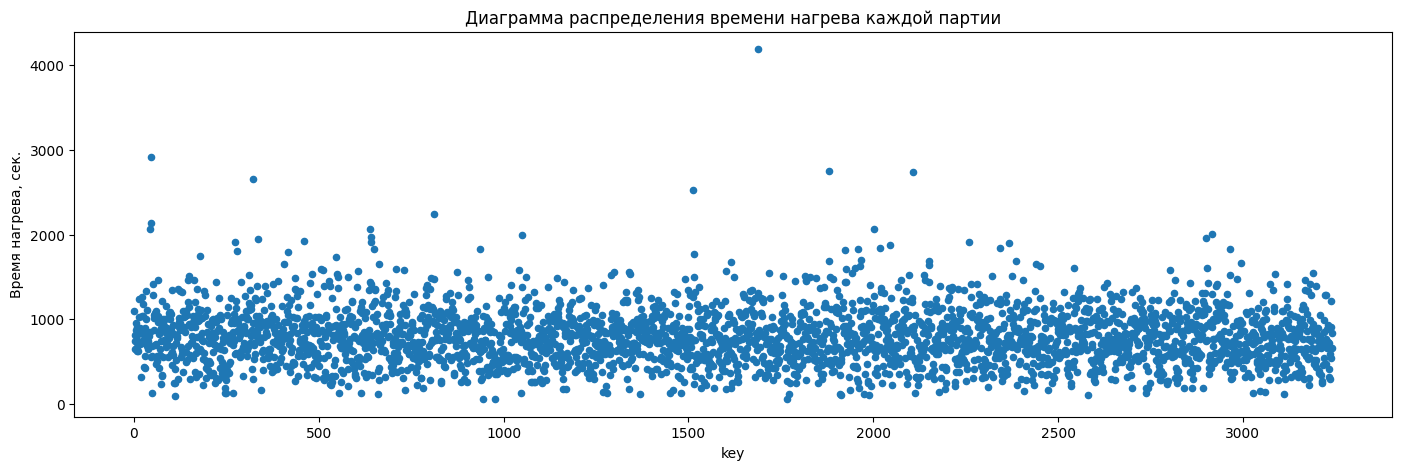

In [60]:
df_all_arc_new_j.plot(x='key', y='Время нагрева, сек.', kind='scatter',  figsize=(17,5))
plt.title('Диаграмма распределения времени нагрева каждой партии')
plt.show()

Время нагрева каждой партии не превышает 50 мин, кроме одного выброса. Медианное время нагрева партии составляет 12-13 мин.

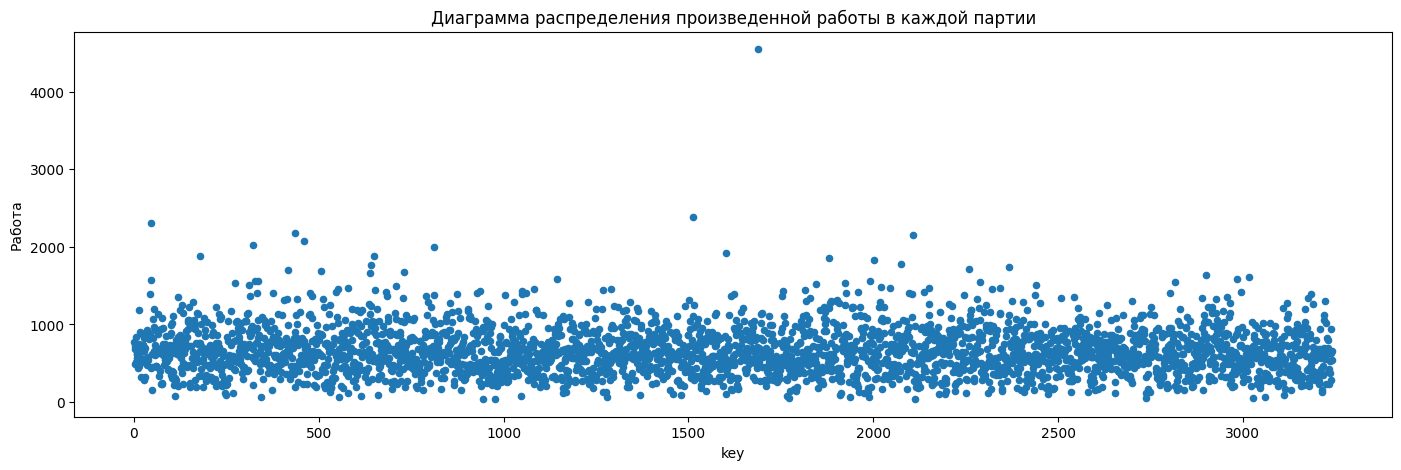

In [61]:
df_all_arc_new_j.plot(x='key', y='Работа', kind='scatter',  figsize=(17,5))
plt.title('Диаграмма распределения произведенной работы в каждой партии')
plt.show()

По графикам видно, что имеется также значительный выброс в данных по работе

In [62]:
max_point = df_all_arc_new_j.loc[(df_all_arc_new_j['Работа'] == df_all_arc_new_j['Работа'].max()), :]
max_point

,key,Число подогревов,Полная мощность,"Время нагрева, сек.",Работа
1672,1689,15,15.288271,4189,4546.405812


Выброс а работе связан с длительным временем между началом и окончанием нагрева. Скорее всего такая продолжительность связана с остановкой процесса, удалим данные по партии как недостоверные.

In [63]:
df_all_arc_new_j = df_all_arc_new_j[df_all_arc_new_j['Работа'] < 3000]

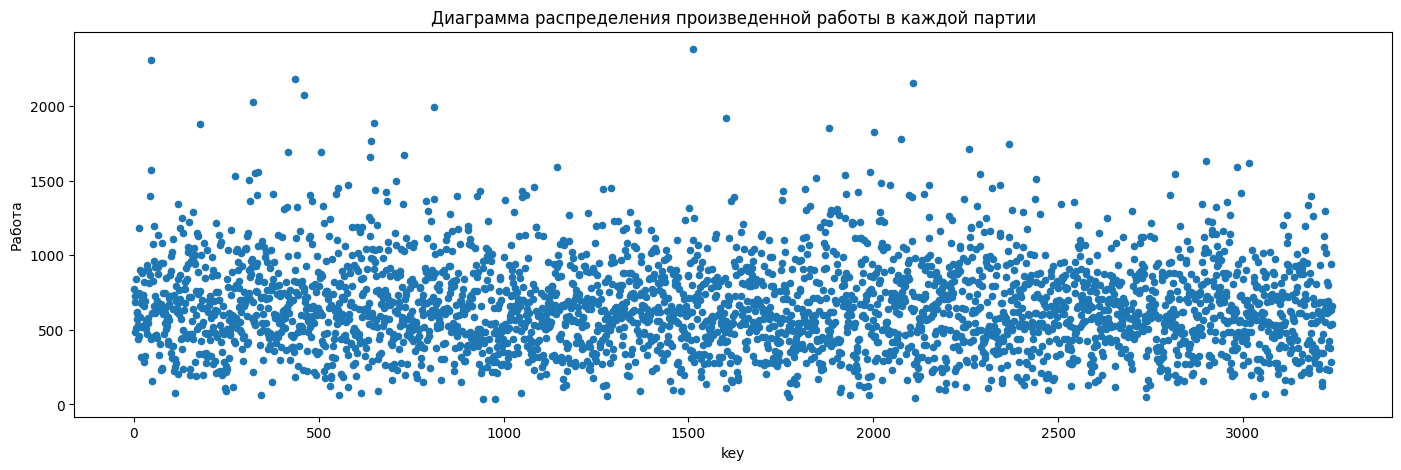

In [64]:
df_all_arc_new_j.plot(x='key', y='Работа', kind='scatter',  figsize=(17,5))
plt.title('Диаграмма распределения произведенной работы в каждой партии')
plt.show()

**Вывод по таблице "Данные об электродах"**:
- Итоговая табл. df_all_arc_new_j
- Для таблицы расчитаны значения полной мощности, суммарного времени нагрева и работы на каждой итерации в партии
- Таблица сгруппирована по уникальным партиям key; значения мощности, времени и работы просуммированы для каждой партии
- Построена диаграмма распределения произведенной работы по каждой партии
- В данных удалены аномальные зачения

### Данные о подаче сыпучих материалов (объём и время)

- Заменим пропущенные значения на 0
- Заменим столбцы, в которых незначительное число присадок одним общим суммарным столбцом

In [65]:
df_bulk_new = data_bulk_new.copy()

In [66]:
#Заменим пропущенные значения на нули
bulk_all = ['Bulk 1', 'Bulk 3', 
            'Bulk 4', 'Bulk 6',
            'Bulk 10', 'Bulk 11', 
            'Bulk 12', 'Bulk 14', 
            'Bulk 15', 'Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']

df_bulk_new[bulk_all] = df_bulk_new[bulk_all].fillna(0)

In [67]:
#заменим столбцы, в которых незначительное число присадок одним общим суммарным столбцом 
bulk_drop = ['Bulk 2', 'Bulk 5', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 13']
df_bulk_new['Bulk_sum'] = df_bulk_new[bulk_drop].sum(axis=1)
df_bulk_new = df_bulk_new.drop(bulk_drop, axis=1)
df_bulk_new.tail(5)

,key,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 12,Bulk 14,Bulk 15,Bulk_sum
3124,3237,0.0,170.0,0.0,0.0,0.0,0.0,252.0,130.0,206.0,0.0
3125,3238,0.0,126.0,0.0,0.0,0.0,0.0,254.0,108.0,106.0,0.0
3126,3239,0.0,0.0,0.0,114.0,0.0,0.0,158.0,270.0,88.0,0.0
3127,3240,0.0,0.0,0.0,26.0,0.0,0.0,0.0,192.0,54.0,0.0
3128,3241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180.0,52.0,0.0


In [68]:
#Расчитаем суммарный объем присадок для каждой уникальной партии key
#df_bulk_new['Bulk_sum'] = df_bulk_new[bulk_sum].sum(axis=1)
#df_bulk_new.head(5)

**Выводы по таблице "Данные о подаче сыпучих материалов (объем)":**
- Итоговая табл. df_bulk_new
- Пропуски заменены на 0
- Малоинформативные столбцы заменены одним суммарным столбцом

### Данные  о продувке сплава газом

- Визуализируем распределение объема газа для продувки каждой партии

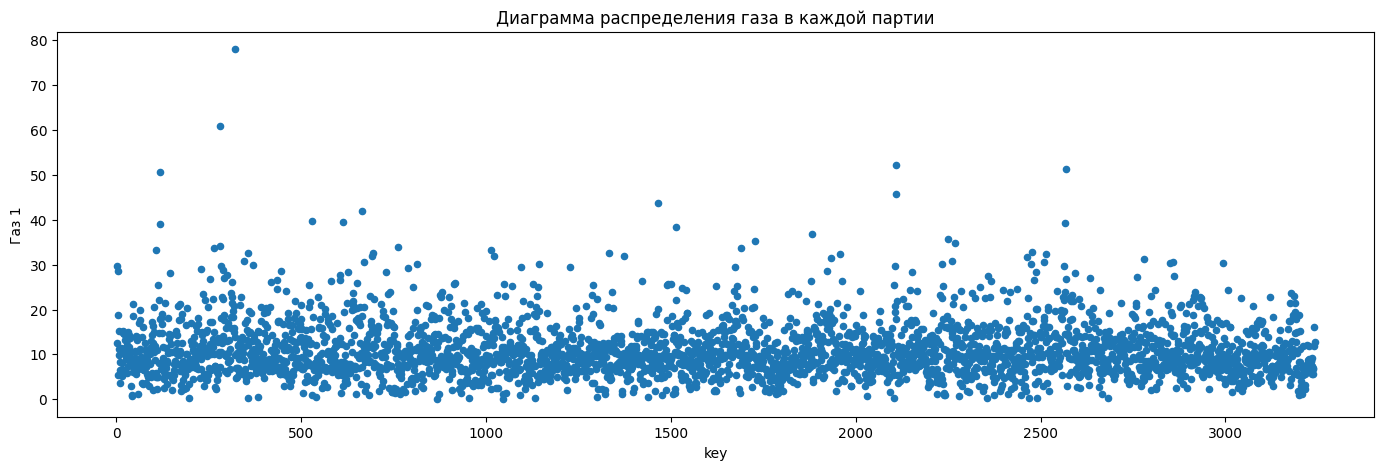

In [69]:
df_gas_new = data_gas_new

df_gas_new.plot(x='key', y='Газ 1', kind='scatter',  figsize=(17,5))
plt.title('Диаграмма распределения газа в каждой партии')
plt.show()

**Выводы по таблице "Данные  о продувке сплава газом":**

Данные адекватные, таблица df_gas_new готова для объединения

### Данные о результатах измерения температуры

- Визуализируем распределение температуры для каждой итерации
- Удалим партии с температурными выбросами ниже 1300 град
- Удалим партии с пропущенными значениями по температуре
- Сгруппируем данные по партии key, добавим столбцы с начальной и конечной измеренными температурами, интервалом между начальным и конечным измерением температуры сплава в ковше

In [70]:
df_temp_new = data_temp_new.copy()

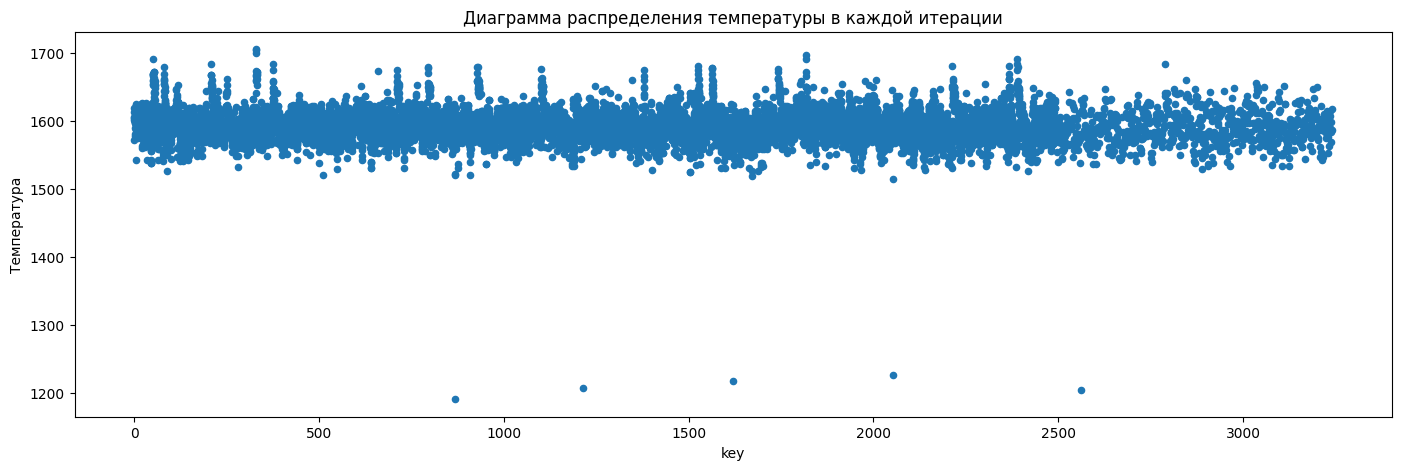

In [71]:
#Визуализируем распределение температуры для каждой итерации
df_temp_new.plot(x='key', y='Температура', kind='scatter',  figsize=(17,5))
plt.title('Диаграмма распределения температуры в каждой итерации')
plt.show()

Температурные выбросы ниже 1300 град удаляем

In [72]:
index_temp = df_temp_new[(df_temp_new['Температура']< 1300)]['key'].unique()
index_drop = df_temp_new.query('key in @index_temp').index
df_temp_new = df_temp_new.drop(index=index_drop)
print('Число удаленных партий',len(index_temp))
print('Число удаленных строк',len(index_drop))
df_temp_new.info()

Число удаленных партий 5
Число удаленных строк 27
<class 'pandas.core.frame.DataFrame'>
Int64Index: 18065 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18065 non-null  int64  
 1   Время замера  18065 non-null  object 
 2   Температура   14643 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 564.5+ KB


In [73]:
#Удалим выбросы, которыхе находятся за пределом трехкратнымого  межвантильного размаха
#Q1 = np.percentile(df_temp_new['Температура'].dropna(), 25, interpolation = 'midpoint')
#Q3 = np.percentile(df_temp_new['Температура'].dropna(), 75, interpolation = 'midpoint')  
#IQR = Q3 - Q1
#index_temp = df_temp_new[(df_temp_new['Температура']<(Q1 - 3*IQR)) |(df_temp_new['Температура']>(Q3 + 3*IQR))]['key'].unique()
#index_drop = df_temp_new.query('key in @index_temp').index
#df_temp_new = df_temp_new.drop(index=index_drop)

В столбце Температура есть пропущенные значения, замених их на 0

In [74]:
df_temp_new['Температура'] = df_temp_new['Температура'].fillna(0)
df_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18065 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           18065 non-null  int64  
 1   Время замера  18065 non-null  object 
 2   Температура   18065 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 564.5+ KB


Удалим партии с пропущенными значениями по температуре

In [75]:
index_temp_0 = df_temp_new[(df_temp_new['Температура'] == 0)]['key'].unique()
index_drop_0 = df_temp_new.query('key in @index_temp_0').index
print('Число удаленных партий',len(index_temp_0))
print('Число удаленных строк',len(index_drop_0))
df_temp_new_0 = df_temp_new.drop(index=index_drop_0)
df_temp_new_0.info()
df_temp_new_0.head(5)

Число удаленных партий 738
Число удаленных строк 4160
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13905 entries, 0 to 13925
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           13905 non-null  int64  
 1   Время замера  13905 non-null  object 
 2   Температура   13905 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 434.5+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0


In [76]:
#Приведем временные данные к типу datetime
df_temp_new_0['Время замера'] = df_temp_new_0['Время замера'].astype('datetime64[ns]')

In [77]:
#Добавим фактор - время между начальным и конечным измерением температуры сплава в ковше
key_unique = df_temp_new_0['key'].unique()
time_start_stop = []
for key in key_unique:
    time_start_stop_0 = (df_temp_new_0[df_temp_new_0['key']==key]['Время замера'].max()-
                  df_temp_new_0[df_temp_new_0['key']==key]['Время замера'].min()).seconds
    time_start_stop.append([key,time_start_stop_0])
temp_interval = pd.DataFrame(time_start_stop,columns = ['key','Измерительный интервал, сек.'])

temp_interval.info()
temp_interval.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 2 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   key                           2473 non-null   int64
 1   Измерительный интервал, сек.  2473 non-null   int64
dtypes: int64(2)
memory usage: 38.8 KB


,key,"Измерительный интервал, сек."
0,1,1714
1,2,1265
2,3,1753
3,4,1220
4,5,1536


Сгруппируем данные по партии key, добавим столбцы с начальной и конечной температурой

In [78]:
key_unique = df_temp_new_0['key'].unique()
df_temp_new2 = []
for key in key_unique:
    len_key_df = df_temp_new_0[df_temp_new_0['key']==key]['key'].count()
    last_temperature = df_temp_new_0[df_temp_new_0['key']==key]['Температура'].iloc[len_key_df-1]
    first_temperature = df_temp_new_0[df_temp_new_0['key']==key]['Температура'].iloc[0]
    df_temp_new2.append([key,first_temperature, last_temperature])  
    
df_temp_new2 = pd.DataFrame(df_temp_new2,columns=['key','Начальная температура сплава','Температура розлива'])
df_temp_new2.info()
df_temp_new2.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2473 entries, 0 to 2472
Data columns (total 3 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   key                           2473 non-null   int64  
 1   Начальная температура сплава  2473 non-null   float64
 2   Температура розлива           2473 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 58.1 KB


,key,Начальная температура сплава,Температура розлива
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0


Добавим в таблицу df_temp_new2 фактор из temp_interval

In [79]:
df_temp_new2 = df_temp_new2.merge(temp_interval, how='inner', on='key')
df_temp_new2.head(5)

,key,Начальная температура сплава,Температура розлива,"Измерительный интервал, сек."
0,1,1571.0,1613.0,1714
1,2,1581.0,1602.0,1265
2,3,1596.0,1599.0,1753
3,4,1601.0,1625.0,1220
4,5,1576.0,1602.0,1536


**Выводы по таблице "Результаты измерения температуры":**
- Итоговая табл. df_temp_new2
- Удалены партии с температурными выбросами и пропущенными значениями по температуре
- Добавлены столбцы с начальной и конечной измеренными температурами
- Добавлен столбец с начальным и конечным измерением температуры сплава в ковше
- Данные сгруппированы по партии key

### Данные о проволочных материалах (объём)

- Заменим пропущенные значения на 0
- Добавим столбец с суммарным объемом проволочных материалов для wire 3 - 9 c незначительным числом данных каждой уникальной партии key

In [80]:
df_wire_new = data_wire_new.copy()

In [81]:
#Заменим пропущенные значения на 0
wire_all= ['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
df_wire_new[wire_all]= df_wire_new[wire_all].fillna(0)

In [82]:
#Расчитаем суммарную массу присадок для каждой партии key с большим числом пропусков
wire_drop = ['Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9']
df_wire_new['Wire_sum'] = df_wire_new[wire_drop].sum(axis=1)
df_wire_new = df_wire_new.drop(wire_drop, axis=1)
df_wire_new.head(5)

,key,Wire 1,Wire 2,Wire_sum
0,1,60.059998,0.00000,0.0
1,2,96.052315,0.00000,0.0
2,3,91.160157,0.00000,0.0
3,4,89.063515,0.00000,0.0
4,5,89.238236,9.11456,0.0


**Выводы по таблице "Данные о подаче сыпучих материалов (объем)":**
- Итоговая табл. df_wire_new
- Расчитан суммарный объем проволочных материалов для каждой уникальной партии key
- Пропуски заменены на 0

### Обобщенная таблица

Сведем полученные данные в одну таблицу. Объединение по key

In [83]:
df_all = (df_all_arc_new_j.merge(df_bulk_new, how='inner', on='key')
                        .merge(df_gas_new, how='inner', on='key')
                        .merge(df_temp_new2, how='inner', on='key')
                        .merge(df_wire_new, how='inner', on='key'))
df_all.info()
df_all.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   key                           2324 non-null   int64  
 1   Число подогревов              2324 non-null   int64  
 2   Полная мощность               2324 non-null   float64
 3   Время нагрева, сек.           2324 non-null   int64  
 4   Работа                        2324 non-null   float64
 5   Bulk 1                        2324 non-null   float64
 6   Bulk 3                        2324 non-null   float64
 7   Bulk 4                        2324 non-null   float64
 8   Bulk 6                        2324 non-null   float64
 9   Bulk 10                       2324 non-null   float64
 10  Bulk 11                       2324 non-null   float64
 11  Bulk 12                       2324 non-null   float64
 12  Bulk 14                       2324 non-null   float64
 13  Bul

,key,Число подогревов,Полная мощность,"Время нагрева, сек.",Работа,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,...,Bulk 14,Bulk 15,Bulk_sum,Газ 1,Начальная температура сплава,Температура розлива,"Измерительный интервал, сек.",Wire 1,Wire 2,Wire_sum
0,1,5,3.718736,1098,770.282114,0.0,0.0,43.0,0.0,0.0,...,150.0,154.0,0.0,29.749986,1571.0,1613.0,1714,60.059998,0.00000,0.0
1,2,4,2.588349,811,481.760005,0.0,0.0,73.0,0.0,0.0,...,149.0,154.0,0.0,12.555561,1581.0,1602.0,1265,96.052315,0.00000,0.0
2,3,5,5.019223,655,722.837668,0.0,0.0,34.0,0.0,0.0,...,152.0,153.0,0.0,28.554793,1596.0,1599.0,1753,91.160157,0.00000,0.0
3,4,4,3.400038,741,683.455597,0.0,0.0,81.0,0.0,0.0,...,153.0,154.0,0.0,18.841219,1601.0,1625.0,1220,89.063515,0.00000,0.0
4,5,4,2.816980,869,512.169934,0.0,0.0,78.0,0.0,0.0,...,151.0,152.0,0.0,5.413692,1576.0,1602.0,1536,89.238236,9.11456,0.0


Обобщенная таблица содержит 2324 объекта, 21 признак и 1 целевой признак. 

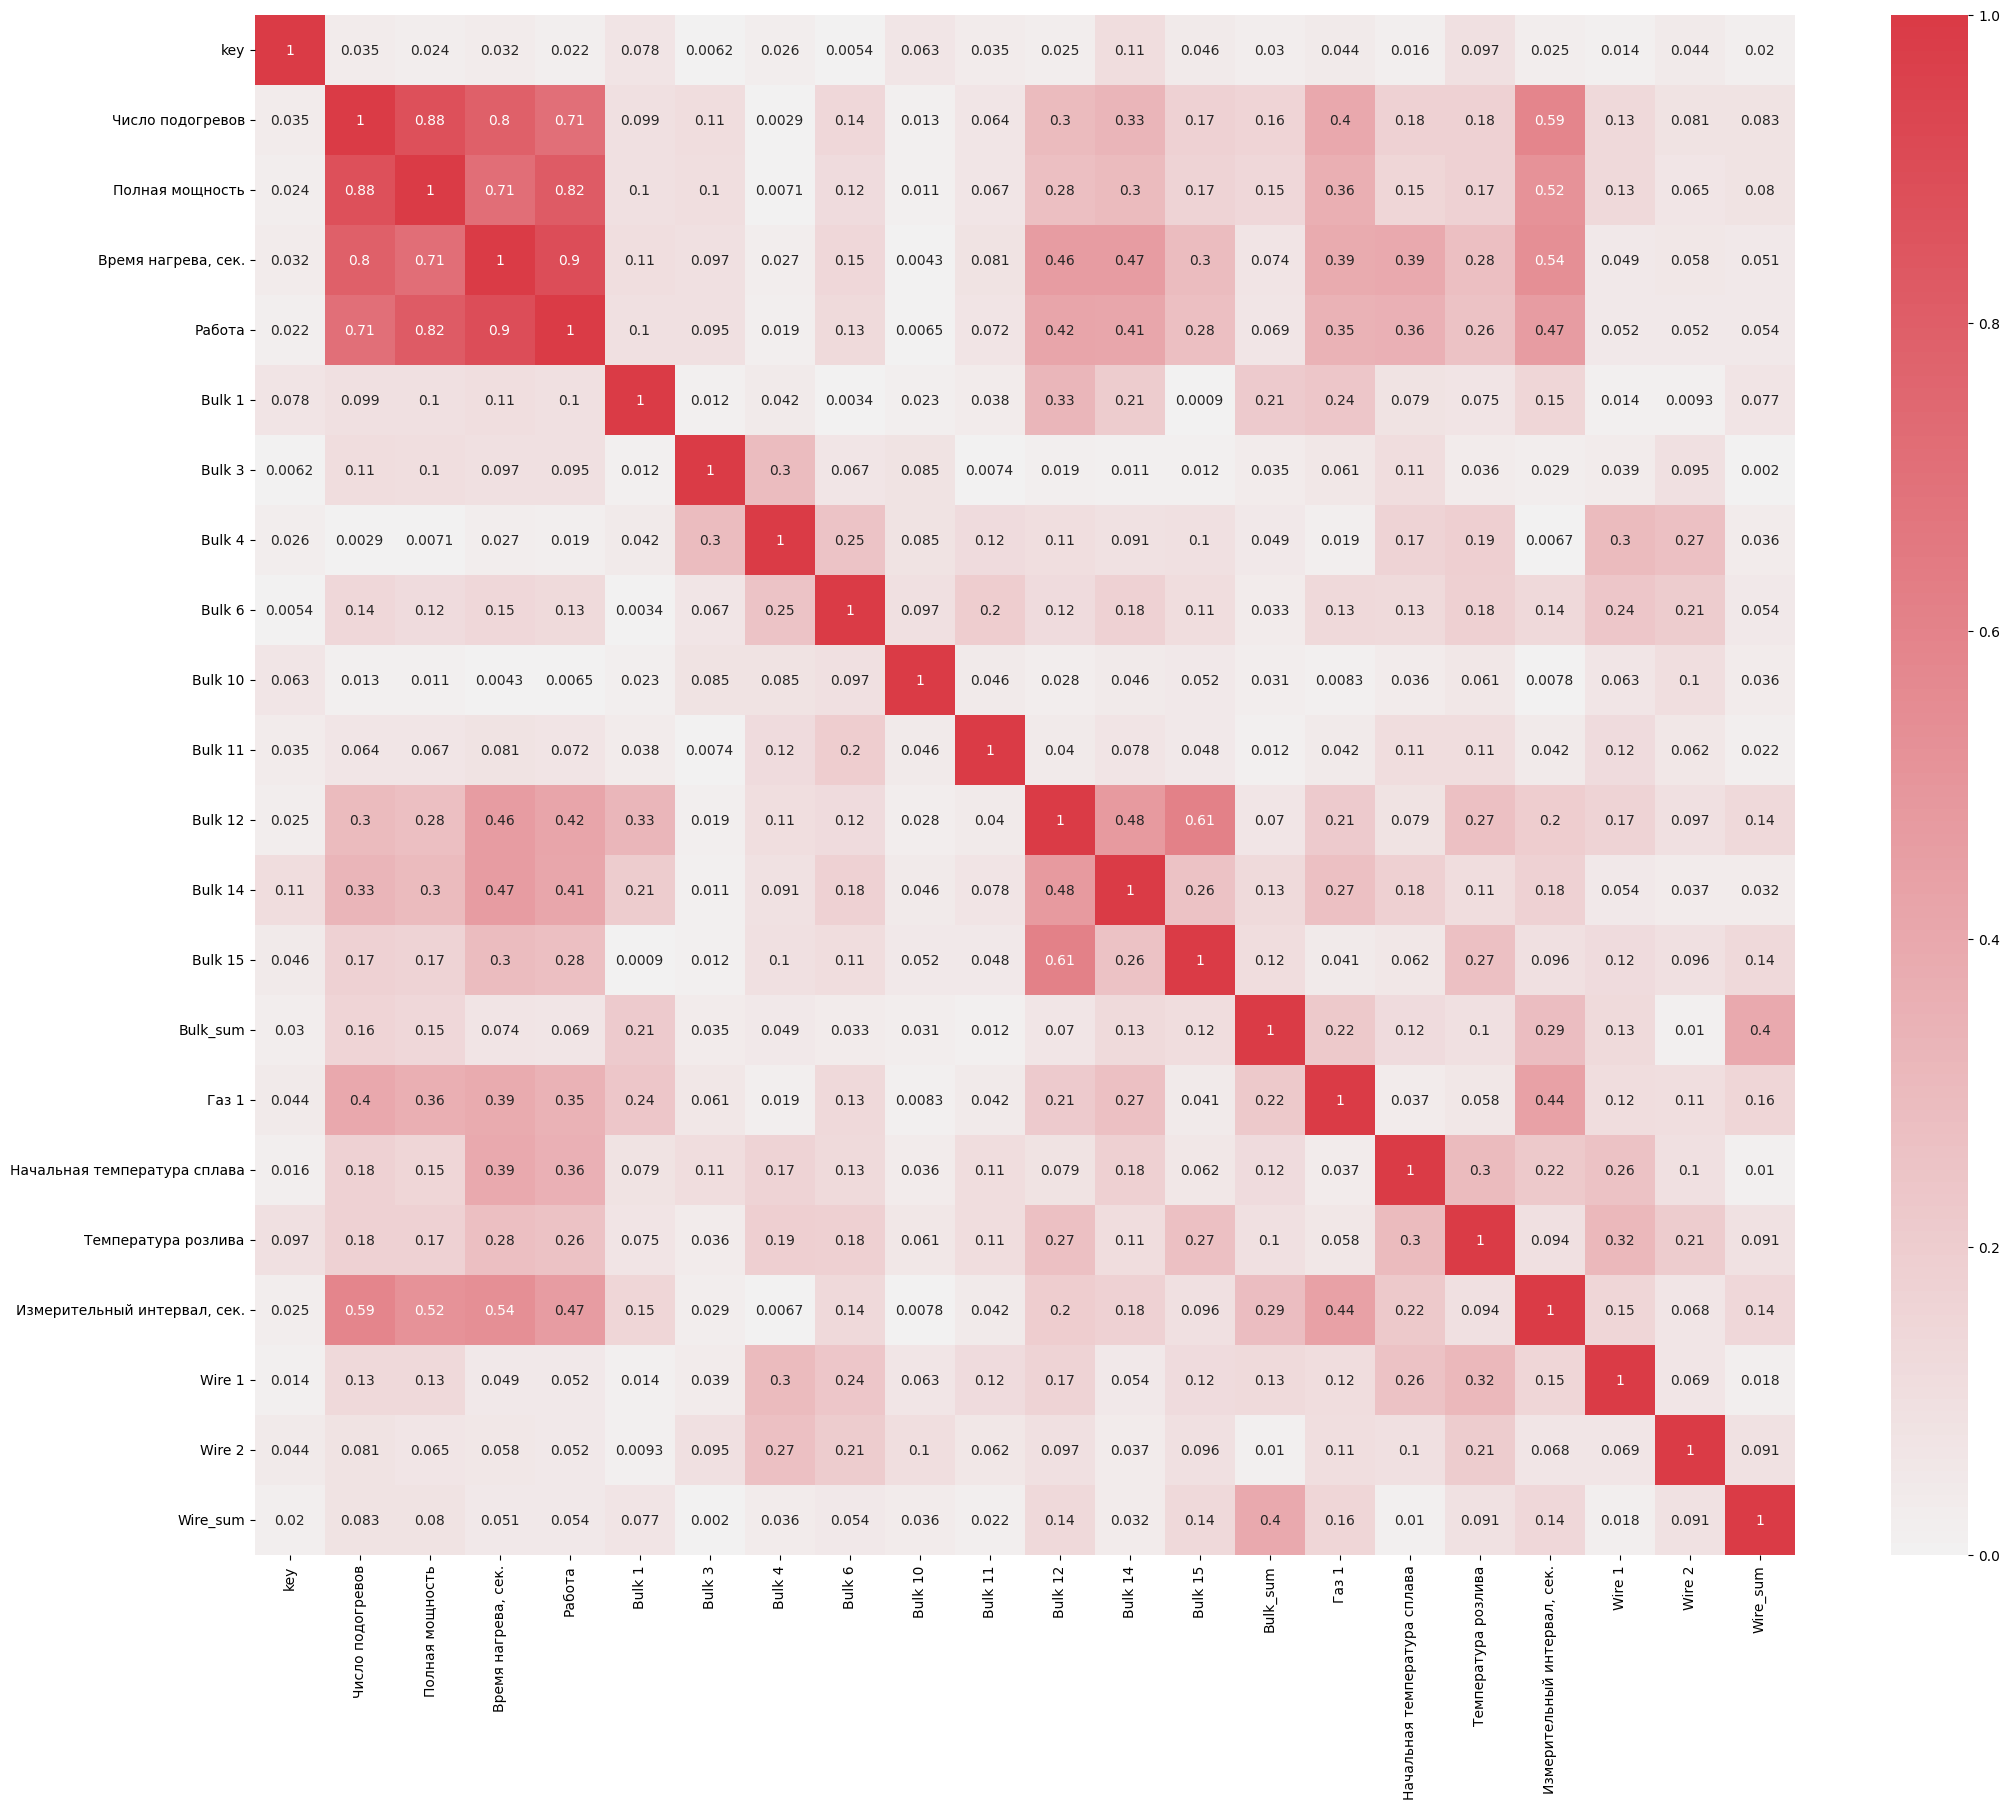

In [84]:
corr = abs(df_all.corr())

f, ax = plt.subplots(figsize=(25, 20))
font = {'size': 10}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr, cmap=cmap, annot=True,    
    vmax=1, vmin=0, center=0,     
    square=True, linewidths=0, 
    xticklabels=True, yticklabels=True
)

По матрице корреляции видна корреляционная зависимость некоторых признаков между собой. Удалим признаки с корреляцией больше 0,6. Т.к. есть зависимость между Bulk 12 и Bulk 15, удалим один из них. Корреляция признаков с целевым признаком Температурой розлива в пределах допустимых значений.
Оставляю два коррелирующих признака "Полная мощность" и "Время нагрева, сек." с корреляцией 0.71. Из данных таблицы data_arc_new это наименее корелирующие между собой факторы.

In [85]:
drop_df = ['Число подогревов',  'Работа', 'Bulk 12', 'key']
df = df_all.drop(drop_df, axis=1)

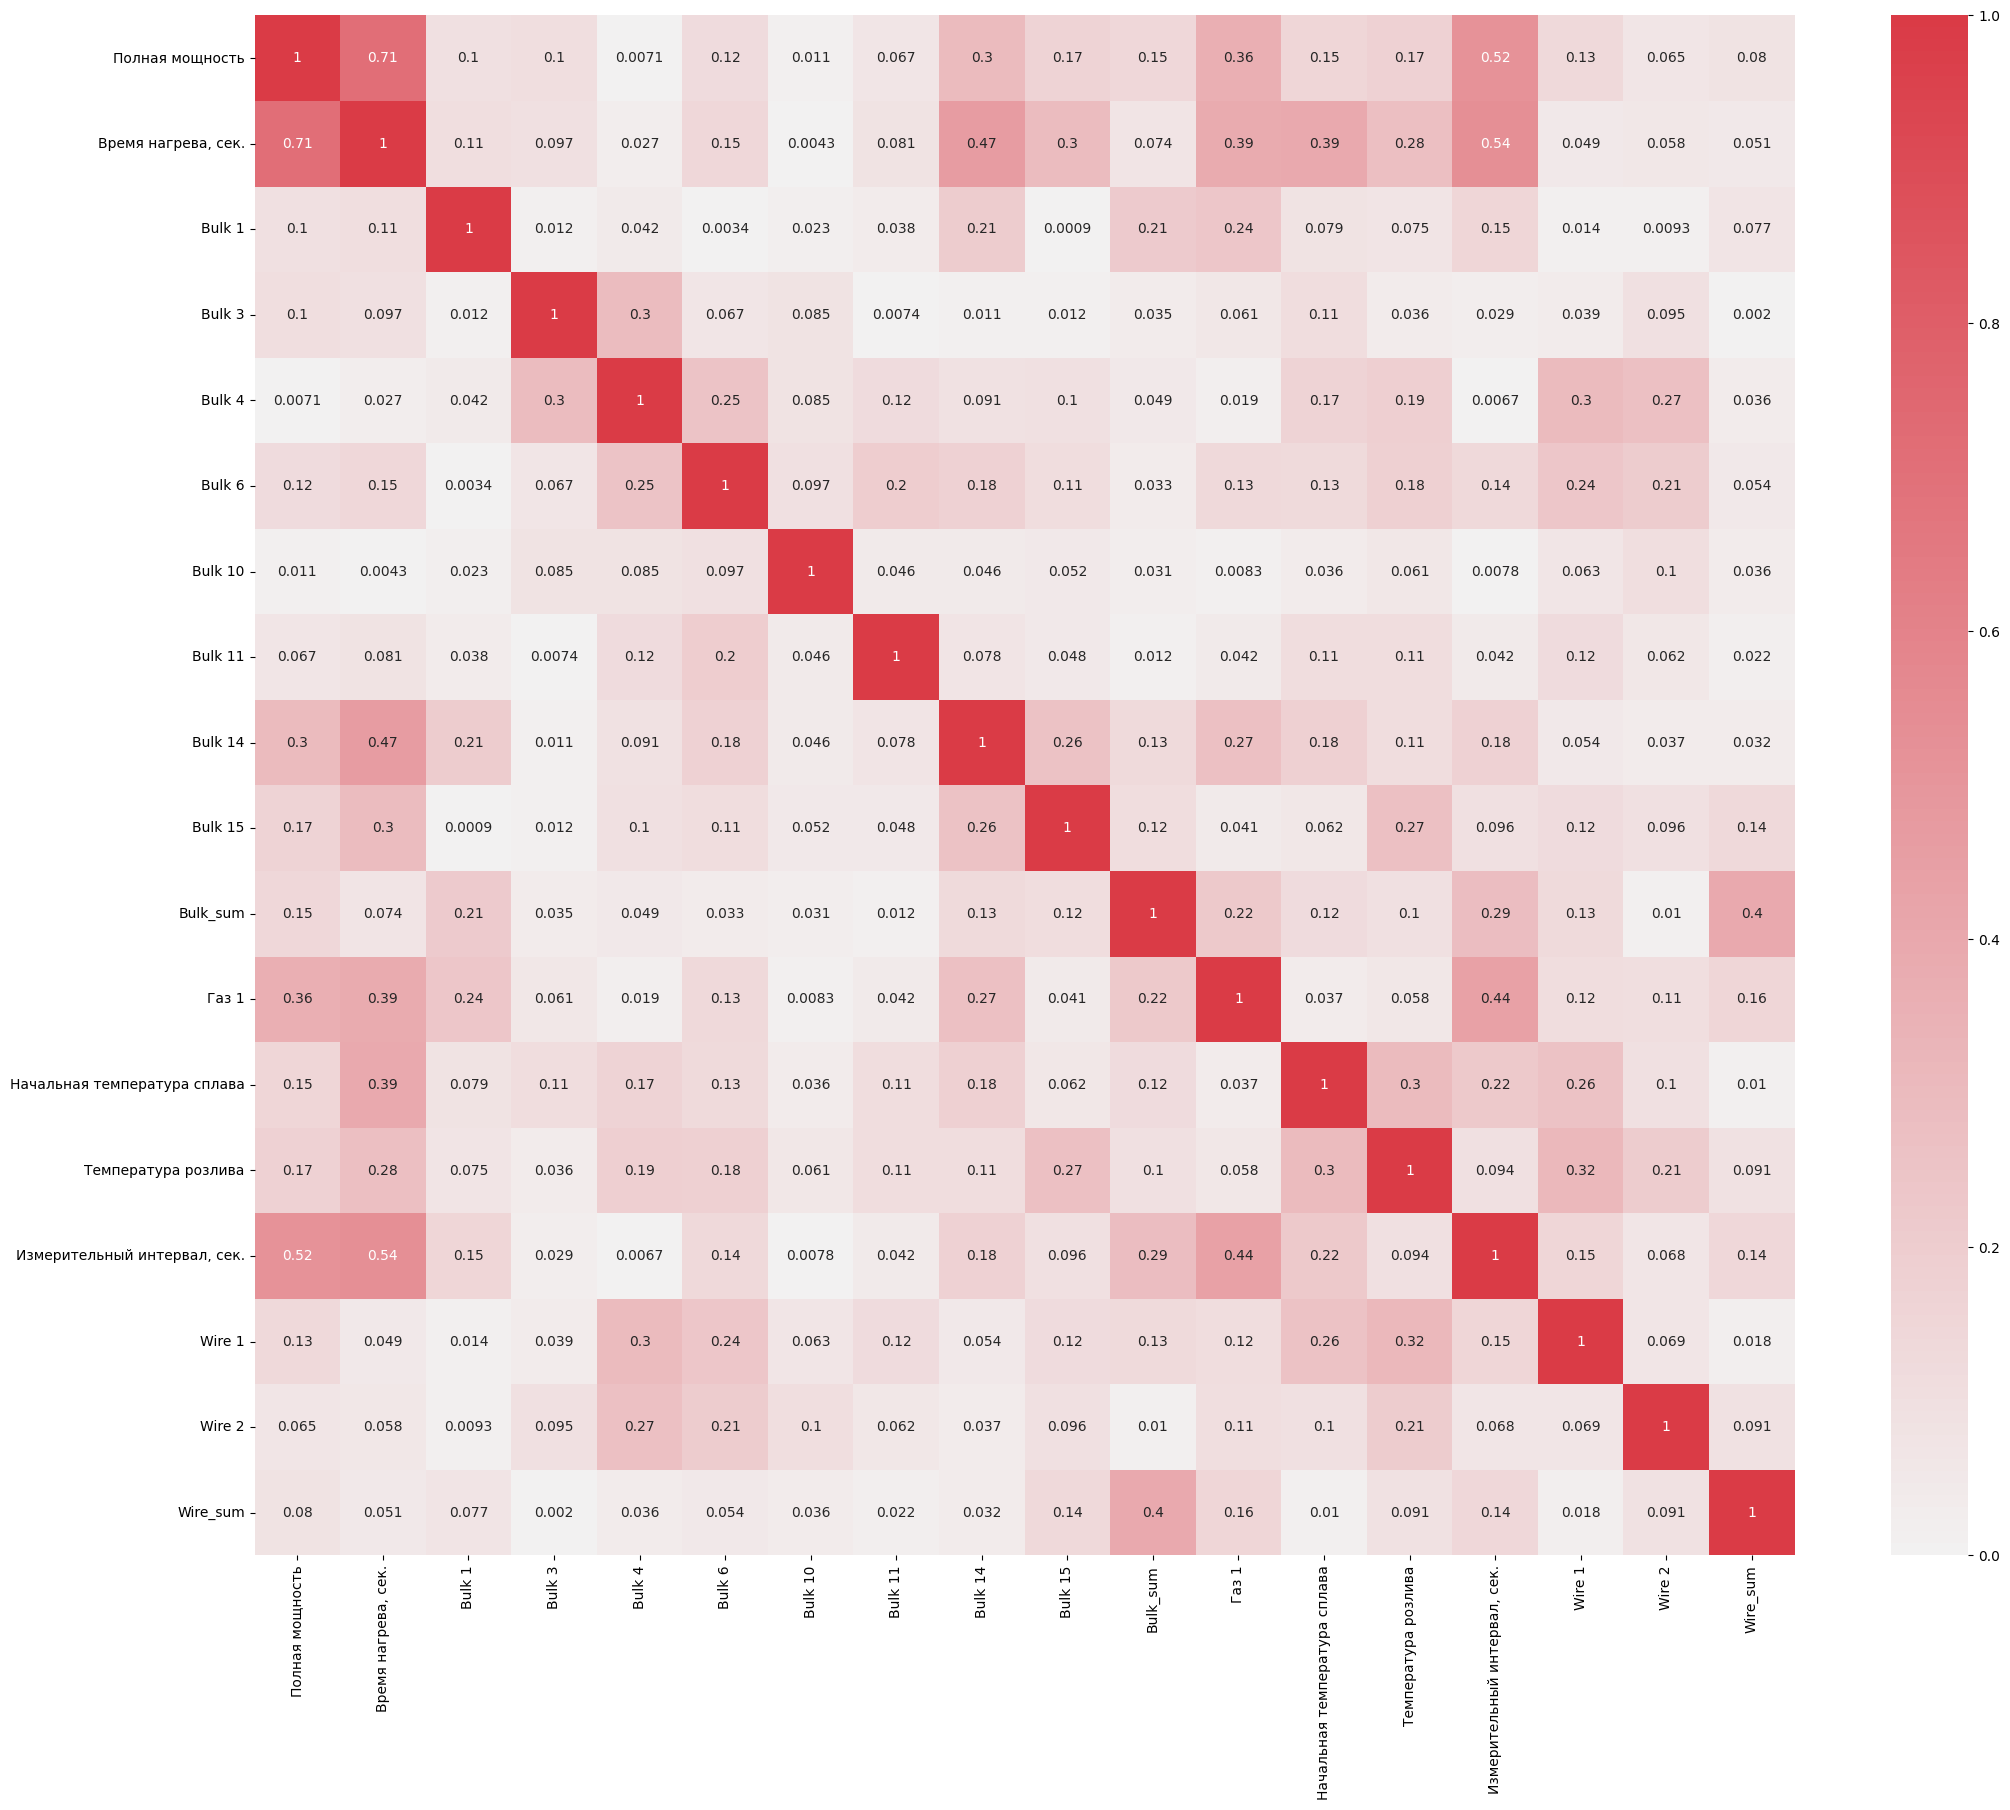

In [86]:
corr = abs(df.corr())

f, ax = plt.subplots(figsize=(25, 20))
font = {'size': 10}
plt.rc('font', **font)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax = sns.heatmap(
    corr, cmap=cmap, annot=True,    
    vmax=1, vmin=0, center=0,     
    square=True, linewidths=0, 
    xticklabels=True, yticklabels=True
)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Полная мощность               2324 non-null   float64
 1   Время нагрева, сек.           2324 non-null   int64  
 2   Bulk 1                        2324 non-null   float64
 3   Bulk 3                        2324 non-null   float64
 4   Bulk 4                        2324 non-null   float64
 5   Bulk 6                        2324 non-null   float64
 6   Bulk 10                       2324 non-null   float64
 7   Bulk 11                       2324 non-null   float64
 8   Bulk 14                       2324 non-null   float64
 9   Bulk 15                       2324 non-null   float64
 10  Bulk_sum                      2324 non-null   float64
 11  Газ 1                         2324 non-null   float64
 12  Начальная температура сплава  2324 non-null   float64
 13  Тем

Обобщенная итоговая таблица содержит 2324 объекта, 17 признаков и 1 целевой признак.

# Вывод по разделу "Предобработка и анализ данных "

**Вывод по таблице "Данные об электродах"**:
- Итоговая табл. df_all_arc_new_j
- Для таблицы расчитаны значения полной мощности, суммарного времени нагрева и работы на каждой итерации в партии
- Таблица сгруппирована по уникальным партиям key; значения мощности, времени и работы просуммированы для каждой партии
- Построена диаграмма распределения произведенной работы по каждой партии
- В данных удалены аномальные зачения

**Выводы по таблице "Данные о подаче сыпучих материалов (объем)":**
- Итоговая табл. df_bulk_new
- Пропуски заменены на 0
- Малоинформативные столбцы заменены одним суммарным столбцом

**Выводы по таблице "Данные  о продувке сплава газом":**
- Итоговая табл. df_gas_new
- Данные адекватные

**Выводы по таблице "Результаты измерения температуры":**
- Итоговая табл. df_temp_new2
- Удалены партии с температурными выбросами и пропущенными значениями по температуре
- Добавлены столбцы с начальной и конечной измеренными температурами
- Добавлен столбец с начальным и конечным измерением температуры сплава в ковше
- Данные сгруппированы по партии key

**Выводы по таблице "Данные о подаче сыпучих материалов (объем)":**
- Итоговая табл. df_wire_new
- Расчитан суммарный объем проволочных материалов для каждой уникальной партии key
- Пропуски заменены на 0

Обработанные данные были сведены в единую таблицу.
Постоена матрица корреляции. 
Удалены признаки с корреляцией больше 0,6. Т.к. есть зависимость между Bulk 12 и Bulk 15, удален один из них. Корреляция признаков с целевым признаком Температурой розлива в пределах допустимых значений.
Оставлены два коррелирующих признака `Полная мощность` и `Время нагрева, сек.` c корреляцией 0.71. 

**Обобщенная итоговая таблица содержит 2324 объекта, 17 признаков и 1 целевой признак.**

# Подготовка данных для обучения

- Выделим в данных целевой признак
- Разделим данные на обучающую и тестовую выборки
- Нормализуем признаки

In [88]:
df

,Полная мощность,"Время нагрева, сек.",Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 10,Bulk 11,Bulk 14,Bulk 15,Bulk_sum,Газ 1,Начальная температура сплава,Температура розлива,"Измерительный интервал, сек.",Wire 1,Wire 2,Wire_sum
0,3.718736,1098,0.0,0.0,43.0,0.0,0.0,0.0,150.0,154.0,0.0,29.749986,1571.0,1613.0,1714,60.059998,0.00000,0.0
1,2.588349,811,0.0,0.0,73.0,0.0,0.0,0.0,149.0,154.0,0.0,12.555561,1581.0,1602.0,1265,96.052315,0.00000,0.0
2,5.019223,655,0.0,0.0,34.0,0.0,0.0,0.0,152.0,153.0,0.0,28.554793,1596.0,1599.0,1753,91.160157,0.00000,0.0
3,3.400038,741,0.0,0.0,81.0,0.0,0.0,0.0,153.0,154.0,0.0,18.841219,1601.0,1625.0,1220,89.063515,0.00000,0.0
4,2.816980,869,0.0,0.0,78.0,0.0,0.0,0.0,151.0,152.0,0.0,5.413692,1576.0,1602.0,1536,89.238236,9.11456,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,3.868721,723,0.0,21.0,0.0,0.0,90.0,0.0,129.0,223.0,0.0,7.125735,1570.0,1591.0,1380,89.150879,0.00000,0.0
2320,5.070316,940,0.0,0.0,63.0,0.0,122.0,0.0,129.0,226.0,0.0,9.412616,1554.0,1591.0,1705,114.179527,0.00000,0.0
2321,4.360918,569,0.0,0.0,85.0,0.0,0.0,0.0,124.0,226.0,0.0,6.271699,1571.0,1589.0,962,94.086723,9.04800,0.0
2322,3.909917,750,0.0,90.0,0.0,0.0,101.0,0.0,129.0,207.0,0.0,14.953657,1591.0,1594.0,1520,118.110717,0.00000,0.0


In [89]:
random_state = 80523

features = df.drop(['Температура розлива'],axis=1) 
target = df['Температура розлива']
X_train, X_test, y_train, y_test= train_test_split(
features, target, test_size=0.25, shuffle=True, random_state=random_state)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape )


(1743, 17) (581, 17) (1743,) (581,)


In [90]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_train.columns)

В данных выделен целевой признак "Температура розлива". Данные разделены на обучающую и тестовую выборки.
Признаки нормализованы, данные подготовлены для обучения.

# Создание и обучение моделей

Подберем и обучим три модели с кросс-валидацией

In [91]:
dct_with_scores = {}
cv = 5

Модель LinearRegression

In [92]:
%%time

model_LR = LinearRegression()
MAE_LR = (cross_val_score(model_LR, 
                             X_train, 
                             y_train, 
                             cv=cv, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE', MAE_LR)

MAE 5.960964695108709
Wall time: 43.6 ms


Модель RandomForestRegressor

In [93]:
%%time
best_model = 20
best_param = 0
for est in range(10, 100, 30):
    for depth in range(2,10,2):
        model_RF = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=random_state)
        MAE_RF = cross_val_score(model_RF, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv)
        final_MAE_RF = MAE_RF.mean()*(-1)

        if final_MAE_RF < best_model:
            best_model = final_MAE_RF
            best_param = [est, depth]
            
print('MAE', best_model)
print('est, depth', best_param)

MAE 6.167565684875278
est, depth [70, 8]
Wall time: 10.4 s


Модель CatBoostRegressor

In [94]:
%%time

regressor = CatBoostRegressor(verbose=False, random_state=random_state)
MAE_CBR = (cross_val_score(regressor, 
                             X_train, 
                             y_train, 
                             cv=cv, 
                             scoring='neg_mean_absolute_error').mean() * -1)
print('MAE', MAE_CBR)
print()
print("Best parameters set found on development set:")
print()
best_params_CBR = CatBoostRegressor(verbose=False, 
                                    random_state=random_state).fit(X_train, 
                                        y_train).get_all_params()
#определение лучших гиперпараметров
best_params_CBR

MAE 5.835610520634085

Best parameters set found on development set:

Wall time: 25.8 s


{'nan_mode': 'Min',
 'eval_metric': 'RMSE',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'random_seed': 80523,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.04470000043511391,
 'score_function

# Вывод по разделу "Создание и обучение моделей "

Созданы модели  LinearRegression, RandomForestRegressor, CatBoostRegressor с кросс-валидацией. Наилучшие показатели МАЕ = 5,8356 у модели CatBoostRegressor

# Тестирование модели

Тестирование проводим на модели CatBoostRegressor, показавшей наилучший результат метрики

In [95]:
%%time

model = CatBoostRegressor(verbose=False)
model.set_params(**best_params_CBR)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
test_MAE_CBR = mean_absolute_error(y_predict, y_test)
print('MAE test', test_MAE_CBR)

MAE test 5.823460041223193
Wall time: 3.98 s


In [96]:
results = {
'Model' : ['LinearRegression','RandomForestRegressor', 'CatBoostRegressor'],
'MAE' :pd.Series([MAE_LR, best_model, 5.8356]),
'Test MAE' : pd.Series(['-', '-', test_MAE_CBR]),

}
display(pd.DataFrame(results))

,Model,MAE,Test MAE
0,LinearRegression,5.960965,-
1,RandomForestRegressor,6.167566,-
2,CatBoostRegressor,5.835600,5.82346


Проведем анализ влияния факторов на целевой признак

In [97]:
importances = model.feature_importances_
feature_list = list(X_train.columns)
feature_results = pd.DataFrame({'Фактор': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)
feature_results

,Фактор,importance
0,"Время нагрева, сек.",23.730061
1,Начальная температура сплава,22.282429
2,"Измерительный интервал, сек.",10.676365
3,Wire 1,7.425039
4,Bulk 15,5.770217
5,Bulk 14,5.459833
6,Bulk 6,4.620559
7,Газ 1,4.257235
8,Полная мощность,4.076834
9,Wire 2,3.782720


# Вывод по разделу "Тестирование модели"

Тестирование проведено для модели CatBoostRegressor, показавшей наилучший результат метрики. На тесте метрика МАЕ показала результат 5.82, что соответствует заявленным требованиям.

Проведен анализ влияния факторов на целевой признак. В результате анализа выявлено, что основное влияние на нагрев оказывает время нагрева и начальная температура сплава.

# Отчет по проекту

**Цель проекта:** Снижение потребления электроэнергии на этапе обработки стали для металлургического комбината ООО «Так закаляем сталь».

**Задача проекта:** Построить модель, которая предскажет температуру стали

**Критерии оценки:** метрика МАЕ. *Условие: МАЕ<=6.8*

**План работы:**
1.	Загрузка и проверка данных
2.	Предобработка и анализ данных
3.	Подготовка данных для обучения
4.	Создание и обучение моделей
5.	Тестирование моделей
6.	Анализ важности факторов**


В соответствии с планом были выполнены следующие этапы работы:

**1.	Загрузка и проверка данных**

Данные загружены из 7 разных источников:

- `data_arc_new` — данные об электродах;
- `data_bulk_new` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time_new` — данные о подаче сыпучих материалов (время);
- `data_gas_new` — данные о продувке сплава газом;
- `data_temp_new` — результаты измерения температуры;
- `data_wire_new` — данные о проволочных материалах (объём);
- `data_wire_time_new` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

**2.	Предобработка и анализ данных**
- Проведена предобработка и анализ данных:
    - Расчитаны значения полной мощности, суммарного времени нагрева и работы на каждой итерации в партии
    - Значения мощности, времени и работы просуммированы для каждой партии
    - Построена диаграмма распределения произведенной работы по каждой партии
    - В данных удалены аномальные зачения
    - Столбцы с низким содержанием информации для Wire и Bulk заменены одним суммарным столбцом
    - Удалены партии с температурными выбросами и пропущенными значениями по целевой температуре
    - Добавлены столбцы с начальной и конечной измеренными температурами
    - Добавлен столбец с начальным и конечным измерением температуры сплава в ковше
- Обработанные данные по каждой уникальной партии сведены в единую таблицу 
- Постоена матрица корреляции
- Удалены признаки с корреляцией больше 0,6. Т.к. есть зависимость между Bulk 12 и Bulk 15, удален один из них. Корреляция признаков с целевым признаком Температурой розлива в пределах допустимых значений.
- Оставлены два коррелирующих признака `Полная мощность` и `Время нагрева, сек.` c корреляцией 0.71. 
- Обобщенная итоговая таблица содержит 2324 объекта, 17 признаков и 1 целевой признак.

**3.	Подготовка данных для обучения**

- В данных выделен целевой признак "Температура розлива". Данные разделены на обучающую 75% и тестовую 25% выборки. Признаки нормализованы, данные подготовлены для обучения.

**4.	Создание и обучение моделей**

- Созданы модели  LinearRegression, RandomForestRegressor, CatBoostRegressor с кросс-валидацией. Наилучшие показатели МАЕ = 5,8356 у модели CatBoostRegressor.  

**5.	Тестирование моделей**

- Тестирование проведено для модели CatBoostRegressor, показавшей наилучший результат метрики. На тесте метрика МАЕ показала результат 5.82, что соответствует заявленным требованиям.

**6.	Анализ важности факторов**

- Проведен анализ влияния факторов на целевой признак. В результате анализа выявлено, что основное влияние на нагрев оказывает время нагрева и начальная температура сплава.

**Все пункты плана выполнены.**

**Задачи выполнены. Цель проекта достигнута.**


